## Finetune VGG16

In [65]:
# setting up stuff
import numpy as np

from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

In [66]:
import cv2
from PIL import Image
from sklearn.metrics import mean_squared_error

In [67]:
from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [68]:
import os
import re

In [70]:
# load the base pre-trained model
base_model = VGG16()

In [72]:
fc2 = base_model.get_layer('fc2').output
fc3 = Dense(1000, activation='relu')(fc2)
predictions = Dense(4)(fc3)

In [73]:
# this is the model we will train
model = Model(base_model.input, predictions)

In [347]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [348]:
for layer in base_model.layers:
    layer.trainable = False

In [244]:
def read_data(folder):
    arr = {}
    base = 'data/{}/Annotations/'.format(folder)
    for file in os.listdir(base):
        with open(base + file) as f:
            z = f.read()
            img = 'data/' + z.split('\n')[2].split()[-1][1:-1].replace('VOC2006', folder)
            z = z.split('\n')[14].split()[-5:]
            k = z[0][1:][:-1], z[1][:-1], z[3][1:][:-1], z[4][:-1]
            k = list(map(int, k))
            arr[img] = k
    return arr

In [245]:
def get_input(folder='dev'):
    X, y = [], []
    data = read_data(folder)
    for img_path, bb in data.items():
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        X.append(x)
        y.append(bb)
    return preprocess_input(np.array(X)), np.array(y)

In [351]:
X, y = get_input('dev')
X_test, y_test = get_input('test')

In [349]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [350]:
model.fit(X, y, epochs=10, batch_size=16)

Epoch 1/10
90/90 [==============================] - 79s - loss: 444.1384     
Epoch 2/10
90/90 [==============================] - 73s - loss: 473.6598     
Epoch 3/10
90/90 [==============================] - 74s - loss: 265.5786     

In [356]:
def test(X, y):
    y_pred = model.predict(X) 
    return y_pred, mean_squared_error(y, y_pred)

In [352]:
def plot_bb(img, bb, bb_pred):
    a,b,c,d = bb
    w,x,y,z = list(map(int, bb_pred))

    fig,ax = plt.subplots(1)
    if isinstance(img, str):
        img = np.array(Image.open(img), dtype=np.uint8)
    ax.imshow(img)
    
    rect = patches.Rectangle((a,b),c-a,d-b, linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    rect2 = patches.Rectangle((w,x),y-w,z-x, linewidth=2,edgecolor='g',facecolor='none')
    ax.add_patch(rect2)
    
    plt.show()

In [353]:
def plot(y, y_pred, folder='dev'):
    num_images = y.shape[0]
    idx = np.random.choice(num_images)
    
    data = read_data(folder)
    img = list(data.keys())[idx]
    plot_bb(img, y[idx], y_pred[idx])

In [376]:
y_pred, mse = test(X, y)

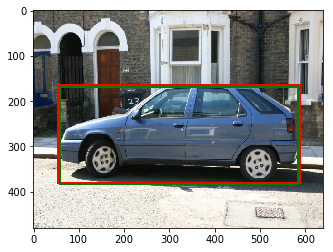

In [398]:
plot(y, y_pred)